In [40]:
import sys
import os


sys.path.append(os.path.abspath("/Users/monika/Desktop/DP/DP_QSAR_Skin_Irritation"))
from imports import *
from matplotlib import pyplot

In [41]:
file_path = '../Features/Rabbit_B_SHAP_XGB2.xlsx'
df = pd.read_excel(file_path)
df.head()

,BertzCT,PEOE_VSA1,HallKierAlpha,EState_VSA3,MinAbsPartialCharge,FpDensityMorgan3,TPSA,VSA_EState8,Kappa1,MinAbsEStateIndex,EState_VSA4,PEOE_VSA6,SlogP_VSA2,VSA_EState5,PEOE_VSA7,EState_VSA8,BalabanJ,Irritation
0,0.334333,1.000000,0.629273,0.000000,0.186733,0.005584,1.000000,0.000000,0.178843,0.121427,0.000000,0.000000,1.000000,0.878471,0.000000,0.000000,0.170558,0
1,0.280977,0.100204,0.503762,0.204207,0.236730,0.512357,0.092188,0.157286,0.080743,0.010083,0.314921,0.290579,0.172717,0.879562,0.335501,0.150392,0.225432,0
2,0.226376,0.063685,0.491727,0.143474,0.311227,0.618976,0.124911,0.268893,0.058238,0.014911,0.000000,0.199785,0.018903,0.888748,0.215532,0.174105,0.249183,1
3,0.082777,0.034327,0.684292,0.049762,0.059691,0.703317,0.042598,0.356660,0.042558,0.016091,0.055666,0.177300,0.035499,0.886025,0.194072,0.272505,0.393213,1
4,0.177621,0.077086,0.496885,0.000000,0.033954,0.307125,0.109581,0.113536,0.041680,0.022782,0.098615,0.187978,0.000000,0.880935,0.251522,0.250251,0.301801,0


In [42]:
df.shape

(703, 18)

In [43]:
print(df.columns.to_list())

['BertzCT', 'PEOE_VSA1', 'HallKierAlpha', 'EState_VSA3', 'MinAbsPartialCharge', 'FpDensityMorgan3', 'TPSA', 'VSA_EState8', 'Kappa1', 'MinAbsEStateIndex', 'EState_VSA4', 'PEOE_VSA6', 'SlogP_VSA2', 'VSA_EState5', 'PEOE_VSA7', 'EState_VSA8', 'BalabanJ', 'Irritation']


In [44]:

X = df.drop(columns=['Irritation']) 
y = df['Irritation']

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15, stratify=y_train)


print(f"Train set: {len(X_train)} samples")
print(f"Validation set: {len(X_valid)} samples")
print(f"Test set: {len(X_test)} samples")


Train set: 477 samples
Validation set: 85 samples
Test set: 141 samples


In [46]:

def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 4, 5),  
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),  
        'n_estimators': trial.suggest_int('n_estimators', 70, 110),  
        'min_child_weight': trial.suggest_int('min_child_weight', 8, 20), 
        'gamma': trial.suggest_float('gamma', 0.5, 2.0), 
        'subsample': trial.suggest_float('subsample', 0.55, 0.75), 
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.75, 0.85),  
        'lambda': trial.suggest_float('lambda', 15, 40),  
        'alpha': trial.suggest_float('alpha', 2, 20),
        'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 20, 50),  
    }

    # Create an XGBoost classifier with the suggested parameters
    model = xgb.XGBClassifier(**params)

    # Using Stratified KFold to split data
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # List to hold cross-validation results
    scores = []

    # Cross-validation with early stopping manually handled
    for train_idx, valid_idx in skf.split(X_train, y_train):
        X_train_cv, X_valid_cv = X_train.iloc[train_idx], X_train.iloc[valid_idx]  
        y_train_cv, y_valid_cv = y_train.iloc[train_idx], y_train.iloc[valid_idx]
        
        # Fit the model on the training fold and validate with early stopping
        model.fit(X_train_cv, y_train_cv, 
                  eval_set=[(X_valid_cv, y_valid_cv)], 
                  verbose=False)
        
        # Get the accuracy for this fold
        y_pred_fold = model.predict(X_valid_cv)
        accuracy = accuracy_score(y_valid_cv, y_pred_fold)

        #y_pred_prob = model.predict_proba(X_valid_cv)[:, 1]
        #accuracy = roc_auc_score(y_valid_cv, y_pred_prob)
        scores.append(accuracy)
    
    # Return the mean accuracy score across all folds
    return np.mean(scores)

# Create a study and optimize it
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))
study.optimize(objective, n_trials=50)

# Print the best parameters and best score
print("Best parameters:", study.best_params)
print("Best score:", study.best_value)

# Train final model with best parameters
best_params = study.best_params
best_params['objective'] = 'binary:logistic'
best_params['eval_metric'] = 'logloss'
best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)

y_pred = best_model.predict(X_train)
final_accuracy = accuracy_score(y_train, y_pred)
print("Final Accuracy on Train Set:", final_accuracy)

y_pred = best_model.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred)
print("Final Accuracy on Test Set:", final_accuracy)


[I 2025-05-11 18:45:50,930] A new study created in memory with name: no-name-f8756aee-ec9e-425b-8bd8-2787302d1a25
[I 2025-05-11 18:45:51,116] Trial 0 finished with value: 0.7799342105263158 and parameters: {'max_depth': 5, 'learning_rate': 0.07520654709893758, 'n_estimators': 81, 'min_child_weight': 9, 'gamma': 1.6721829001320703, 'subsample': 0.6477500401373397, 'colsample_bytree': 0.8283423709952074, 'lambda': 28.915520118682004, 'alpha': 4.229444237101815, 'early_stopping_rounds': 33}. Best is trial 0 with value: 0.7799342105263158.
[I 2025-05-11 18:45:51,262] Trial 1 finished with value: 0.7757017543859648 and parameters: {'max_depth': 4, 'learning_rate': 0.07511369923325283, 'n_estimators': 95, 'min_child_weight': 10, 'gamma': 0.5379358292839246, 'subsample': 0.7048923113921552, 'colsample_bytree': 0.7952685439524158, 'lambda': 31.973222973896245, 'alpha': 15.666339966890671, 'early_stopping_rounds': 38}. Best is trial 0 with value: 0.7799342105263158.
[I 2025-05-11 18:45:51,409] 

Best parameters: {'max_depth': 4, 'learning_rate': 0.05536245403465397, 'n_estimators': 98, 'min_child_weight': 14, 'gamma': 0.6806686066598358, 'subsample': 0.7006589719199023, 'colsample_bytree': 0.8117844009762951, 'lambda': 21.825225204888717, 'alpha': 4.391383643422381, 'early_stopping_rounds': 43}
Best score: 0.7946052631578947
Final Accuracy on Train Set: 0.8029350104821803
Final Accuracy on Test Set: 0.8156028368794326


In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15, stratify=y_train)
best_params = study.best_params

# Initialize the model with best parameters
final_model = xgb.XGBClassifier(**best_params, eval_metric='logloss', use_label_encoder=False)

# Fit the model with early stopping using the validation set
final_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],  # Including both train and validation for evaluation
    verbose=False
)

# Evaluate accuracy on test data
test_accuracy = final_model.score(X_test, y_test)
train_accuracy = final_model.score(X_train, y_train)
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

y_pred = final_model.predict(X_test)

# Metrics
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')


print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Train Accuracy: 0.8205128205128205
Test Accuracy: 0.8113207547169812
Precision: 0.7619047619047619
Recall: 0.9056603773584906
F1 Score: 0.8275862068965517


In [62]:
test_accuracies = []
train_accuracies = []

for _ in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y)

    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15, stratify=y_train)

    best_params = study.best_params


    final_model = xgb.XGBClassifier(**best_params, eval_metric='logloss', use_label_encoder=False)

    final_model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],  
        verbose=False
    )

    test_accuracy = final_model.score(X_test, y_test)
    train_accuracy = final_model.score(X_train, y_train)
    #print("Train Accuracy:", train_accuracy)
    #print("Test Accuracy:", test_accuracy)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

print(np.mean(train_accuracies), np.mean(test_accuracies))

0.8189349112426034 0.809433962264151


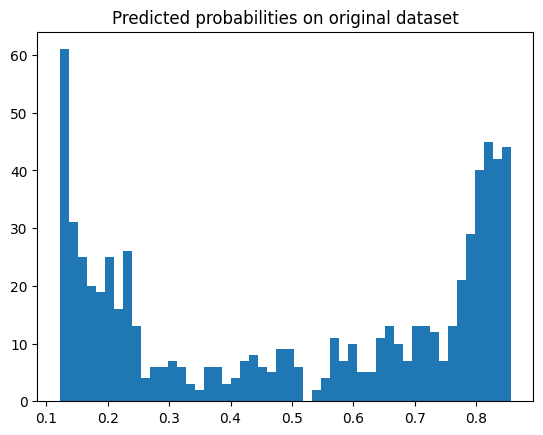

In [63]:

probs = final_model.predict_proba(X)[:, 1]
plt.hist(probs, bins=50)
plt.title("Predicted probabilities on original dataset")
plt.show()


Train Accuracy: 0.8264299802761341
Test Accuracy: 0.7924528301886793


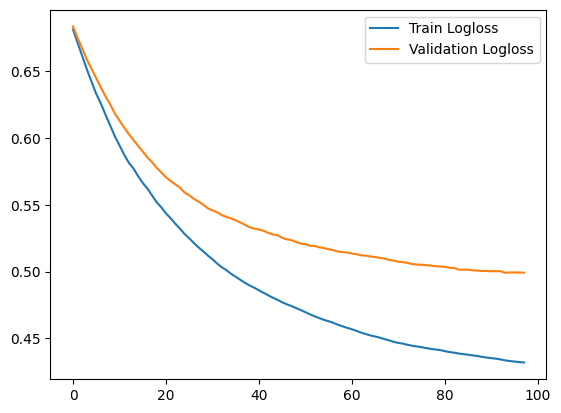

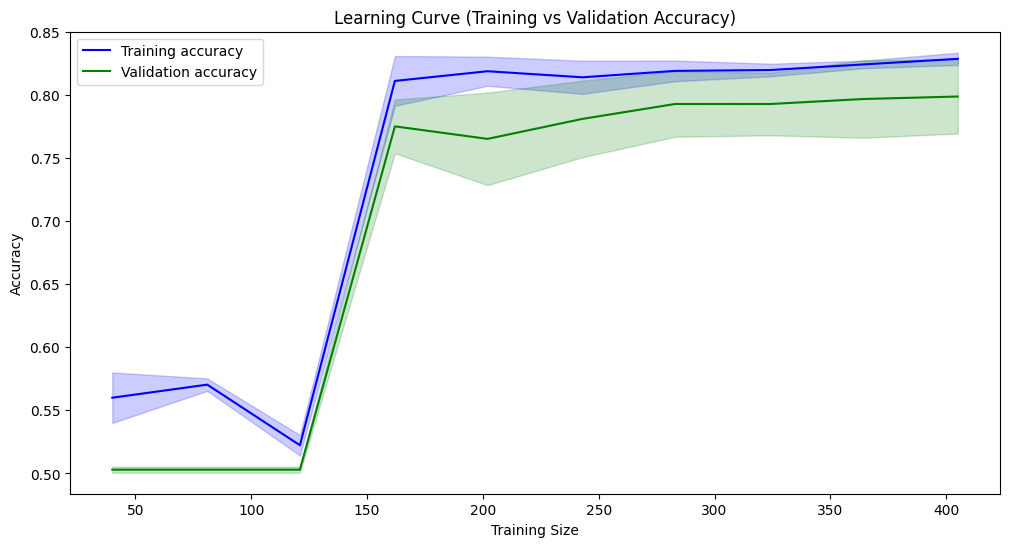

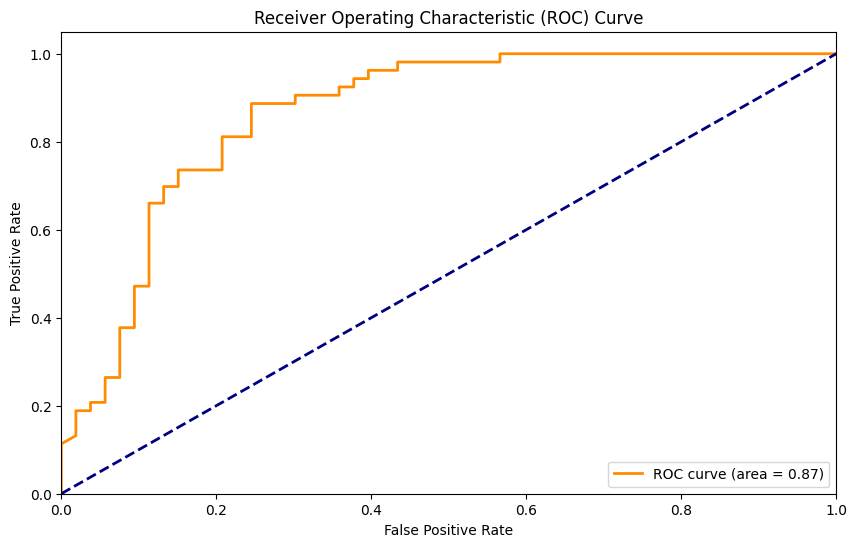

In [51]:

best_params = study.best_params

# Initialize the model with best parameters
final_model = xgb.XGBClassifier(**best_params, eval_metric='logloss', use_label_encoder=False)

# Fit the model with early stopping using the validation set
final_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],  # Including both train and validation for evaluation
    verbose=0
)

# Evaluate accuracy on test data
test_accuracy = final_model.score(X_test, y_test)
train_accuracy = final_model.score(X_train, y_train)
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)


# Get the evaluation results from the training process
results = final_model.evals_result()

# Check if 'validation_1' exists in the results
if 'validation_1' in results:
    # Plot learning curves for training and validation
    pyplot.plot(results['validation_0']['logloss'], label='Train Logloss')
    pyplot.plot(results['validation_1']['logloss'], label='Validation Logloss')
else:
    print("Validation set logloss not found in the results")

# Show the legend and plot
pyplot.legend()
pyplot.show()

# Learning Curves with Early Stopping
train_sizes, train_scores, validation_scores = learning_curve(
    clone(final_model),  # ensures a clean model each time
    X_train, y_train,
    cv=5,
    n_jobs=-1,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    fit_params={
        'eval_set': [(X_valid, y_valid)],
        'verbose': False 
    }
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
validation_mean = np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)

# Plot Learning Curve
plt.figure(figsize=(12, 6))
plt.plot(train_sizes, train_mean, label='Training accuracy', color='blue')
plt.plot(train_sizes, validation_mean, label='Validation accuracy', color='green')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, validation_mean - validation_std, validation_mean + validation_std, color='green', alpha=0.2)
plt.title('Learning Curve (Training vs Validation Accuracy)')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# AUC-ROC Plot
# Get predicted probabilities for the positive class
y_prob = final_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate AUC (Area Under Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [52]:
explainer = shap.Explainer(final_model)
shap_values = explainer.shap_values(X_train)


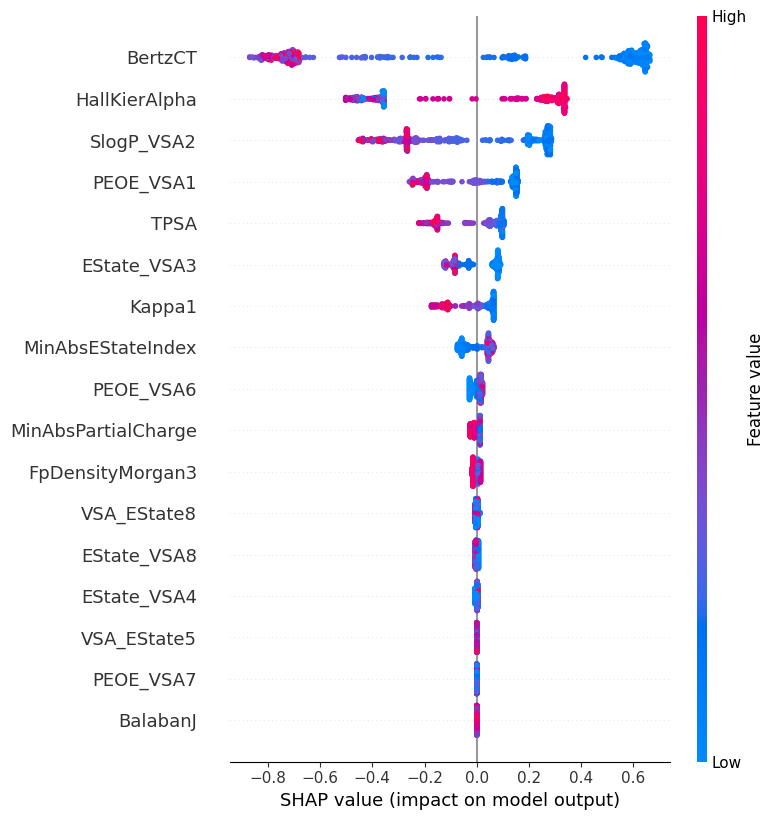

In [53]:
shap.summary_plot(shap_values, X_train)

In [54]:
import joblib

joblib.dump(final_model, 'xgb_model2.pkl')

print("Model saved successfully!")


Model saved successfully!
